# Cycle sale analysis

This is a notebook preceeding after SQL script and Tableau analysis. The main focus on this notebook is to perform statistical analysis, to determine if a relation between predoctors exists statistically.

Clustering analysis is also performed to determine if customers with certain demographic information can be grouped.
![](download.webp)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import scipy

# Bike sales analysis

This notebook is a preceeding analysis from previous [SQL](https://github.com/ShiYang1101/cycle_sales/blob/master/sales.sql) and [Tableau](https://public.tableau.com/views/bikesalesanalysis_16728519380800/Distributionsofunitpricesacrossproductcategories_?:language=en-GB&:display_count=n&:origin=viz_share_link) analysis. 

A short summary of the previous analysis:

* The revenues generated for each age group roughly follows a normal distribution, centering at 28-31.
* The recorded sales starts from January 2015 until July 2016.
* There was a huge increase in sales starting July 2015, with 140 percentage increase from June.
* The product with highest revenue is bike sales
* The highest single transaction is of bike rakes, with revenue of $5073.
* California and England contributes to most of the increase in July 2015.
* Clothing and accesorries were only introduced after July 2015, which is the majot contributor for revenue increase.
* The profit of bike sales are roughly a normal distribution, with high percentage of it located at negative values.
* Bike sales has negative profit before 2016.

The purpose of the notebook is to investigate that:
1. The reason behind bike sales having negative profit before 2016.
1. Relation between age group, revenue, profit. Are the relation statistically significant?
1. Clustering of customers demographic data, determine which groups generates higest proft.


In [2]:
#| output: false
!pip install optuna

## Basic EDA

Let's have a look at the dataframe we will be working with:

In [3]:
sales_df = pd.read_csv('./sales_cleaned.csv', index_col='index')
sales_df.head()

Date  Year     Month  Customer Age Customer Gender        Country  \
index                                                                          
0      02/19/16  2016  February            29               F  United States   
1      02/20/16  2016  February            29               F  United States   
2      02/27/16  2016  February            29               F  United States   
3      03/12/16  2016     March            29               F  United States   
4      03/12/16  2016     March            29               F  United States   

            State Product Category     Sub Category  Quantity  Unit Cost  \
index                                                                      
0      Washington      Accessories  Tires and Tubes       1.0      80.00   
1      Washington         Clothing           Gloves       2.0      24.50   
2      Washington      Accessories  Tires and Tubes       3.0       3.67   
3      Washington      Accessories  Tires and Tubes       2.0      87.50   
4      Washington      Accessories  Tires and Tubes       3.0      35.00   

       Unit Price   Cost  Revenue  net_profit  Day  Month_numeric  
index                                                              
0      109.000000   80.0    109.0          29   19              2  
1       28.500000   49.0     57.0           8   20              2  
2        5.000000   11.0     15.0           4   27              2  
3      116.500000  175.0    233.0          58   12              3  
4       41.666667  105.0    125.0          20   12              3

In [4]:
print(f"The dataframe has {sales_df.shape[0]} rows and {sales_df.shape[1]} features")

The dataframe has 34866 rows and 17 features


From the dataframe, we can see that this is a fairly standard database, where interesting columns are categorical features:
* Countries/States
* Product categories/sub-categories
* Customer's gender

and the numeric features:
* Cost
* Revenue
* Profit
* Customer's age

ALthough datetime features are also included in the dataframe, we will be ignoring these since the time-series analysis was analysed in our [Tableau](https://public.tableau.com/views/bikesalesanalysis_16728519380800/Distributionsofunitpricesacrossproductcategories_?:language=en-GB&:display_count=n&:origin=viz_share_link) and SQL analysis.

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34866 entries, 0 to 34865
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              34866 non-null  object 
 1   Year              34866 non-null  int64  
 2   Month             34866 non-null  object 
 3   Customer Age      34866 non-null  int64  
 4   Customer Gender   34866 non-null  object 
 5   Country           34866 non-null  object 
 6   State             34866 non-null  object 
 7   Product Category  34866 non-null  object 
 8   Sub Category      34866 non-null  object 
 9   Quantity          34866 non-null  float64
 10  Unit Cost         34866 non-null  float64
 11  Unit Price        34866 non-null  float64
 12  Cost              34866 non-null  float64
 13  Revenue           34866 non-null  float64
 14  net_profit        34866 non-null  int64  
 15  Day               34866 non-null  int64  
 16  Month_numeric     34866 non-null  int64 

In [6]:
sales_df.describe()

Year  Customer Age      Quantity     Unit Cost    Unit Price  \
count  34866.000000  34866.000000  34866.000000  34866.000000  34866.000000   
mean    2015.569237     36.382895      2.002524    349.880567    389.232485   
std        0.495190     11.112902      0.813936    490.015846    525.319091   
min     2015.000000     17.000000      1.000000      0.670000      0.666667   
25%     2015.000000     28.000000      1.000000     45.000000     53.666667   
50%     2016.000000     35.000000      2.000000    150.000000    179.000000   
75%     2016.000000     44.000000      3.000000    455.000000    521.000000   
max     2016.000000     87.000000      3.000000   3240.000000   5082.000000   

               Cost       Revenue    net_profit           Day  Month_numeric  
count  34866.000000  34866.000000  34866.000000  34866.000000   34866.000000  
mean     576.004532    640.870074     64.865542     15.667671       6.317845  
std      690.500395    736.650597    152.879908      8.770677       3.465317  
min        2.000000      2.000000   -937.000000      1.000000       1.000000  
25%       85.000000    102.000000      5.000000      8.000000       3.000000  
50%      261.000000    319.000000     27.000000     16.000000       6.000000  
75%      769.000000    902.000000     96.000000     23.000000       9.000000  
max     3600.000000   5082.000000   1842.000000     31.000000      12.000000

It appears that most of the distribution are a long tailed distribution, skewed to the lower end.

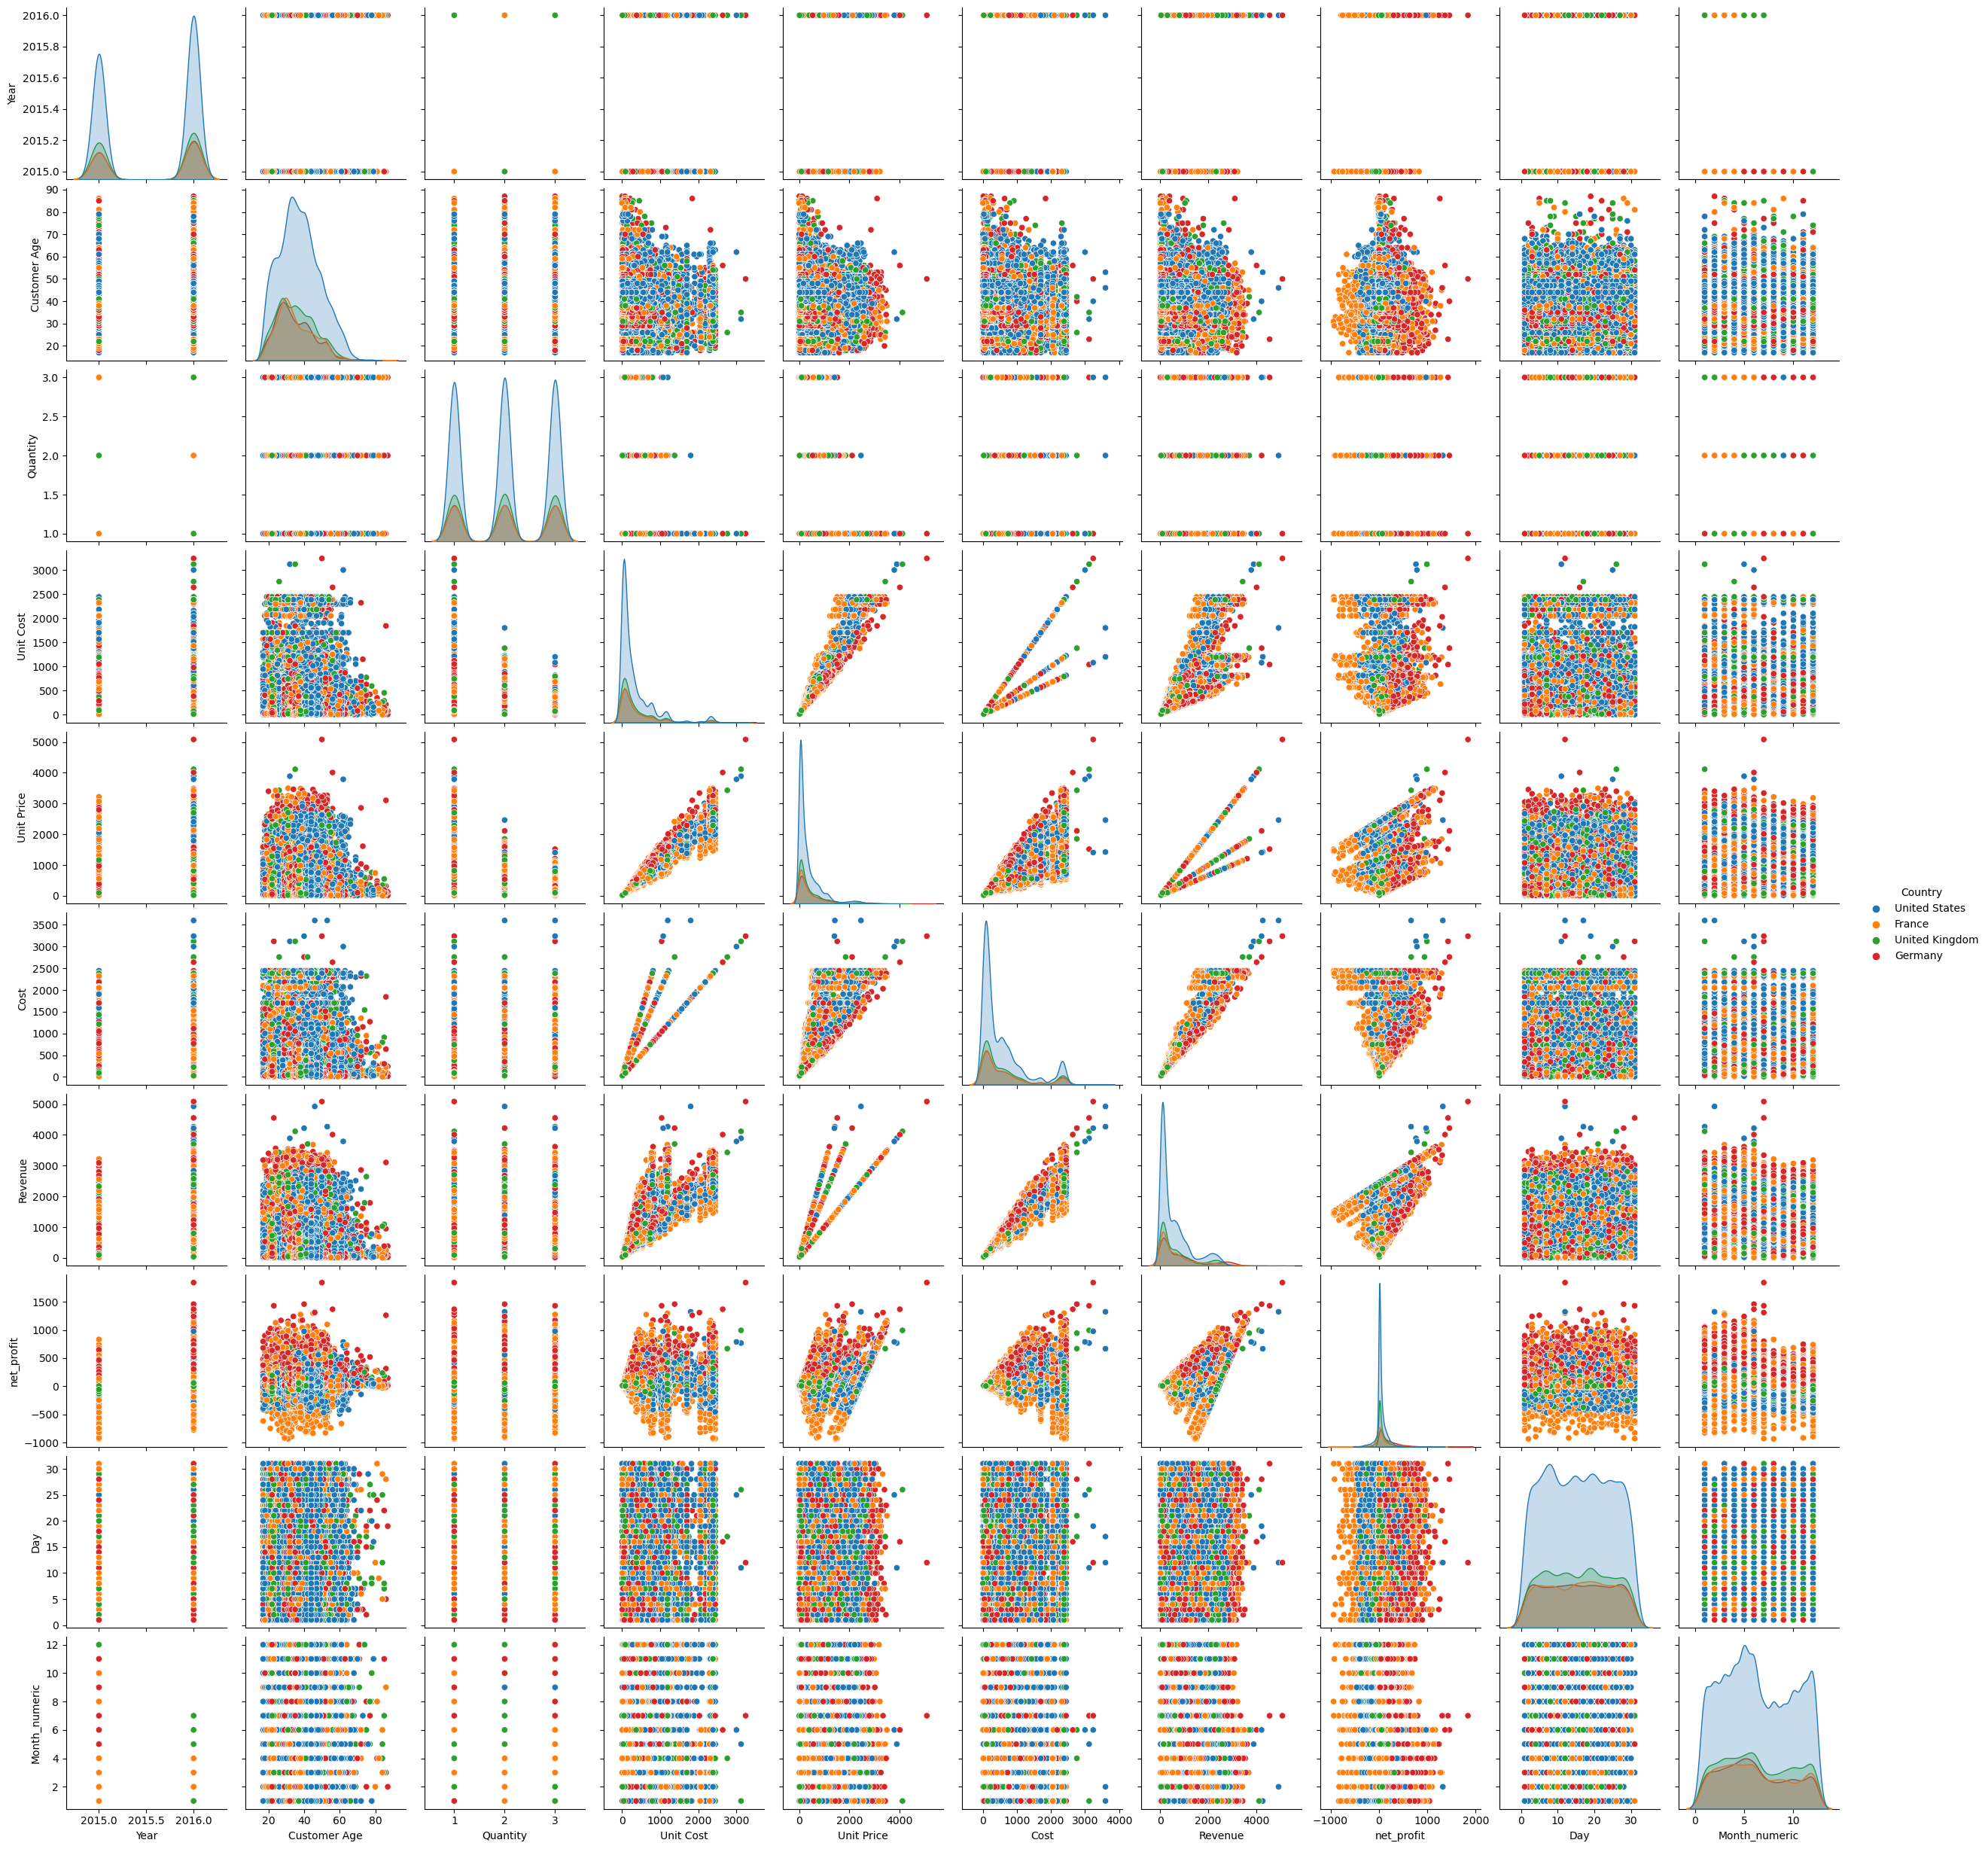

In [7]:
#| label: pairplot
#| fig-cap: Pair-plot for the relations between numeric values.
sns.pairplot(sales_df, hue='Country')
plt.show()

From the plot above, we can see that there isn't immediate linear relation besides of revenue, price, cost and profit. However, one thing to note is the cluster of net profit and countries. Although not obcious, Germany seems to be clustered at the higher end of profit generated.

>> To be determined, does sales in Germany generate more profit?

### Duplicates

As standard procedure, we will be checking if there is any duplicated information hidden in the dataframe.

Duplicates will be a problem for statistical testing, as the degree of freedom will be overly estimated, producing inaccurate confidence interval and p-values.

If a regression model were to be run, the duplicated values will also produce incorrect confidence and prediction intervals. However, since this is a fairly straightforward dataframe with no predictive value, this is not an issue here.

In [8]:
sales_df.duplicated().mean()

2.868123673492801e-05

In [9]:
sales_df[sales_df.duplicated(keep=False)].sort_values(['Date', 'Revenue'])

Date  Year   Month  Customer Age Customer Gender  Country   State  \
index                                                                          
868    08/12/15  2015  August            43               F  Germany  Bayern   
869    08/12/15  2015  August            43               F  Germany  Bayern   

      Product Category       Sub Category  Quantity  Unit Cost  Unit Price  \
index                                                                        
868        Accessories  Bottles and Cages       2.0       10.0        14.0   
869        Accessories  Bottles and Cages       2.0       10.0        14.0   

       Cost  Revenue  net_profit  Day  Month_numeric  
index                                                 
868    20.0     28.0           8   12              8  
869    20.0     28.0           8   12              8

Out of 34866 entries, there was one entry that appears to be duplicated. It is quite possible that one person with the same demographic information purchased the exact same item on the same day. We will leave the duplicated entry as it is only one of them.

### Univariate analysis

In [10]:
num_col = sales_df.select_dtypes('number').columns
cat_col = sales_df.select_dtypes('object').columns
cat_col

Index(['Date', 'Month', 'Customer Gender', 'Country', 'State',
       'Product Category', 'Sub Category'],
      dtype='object')

In [11]:
sales_df.nunique().sort_values()

Year                   2
Customer Gender        2
Quantity               3
Product Category       3
Country                4
Month_numeric         12
Month                 12
Sub Category          17
Day                   31
State                 45
Customer Age          70
Cost                 417
Date                 576
Unit Cost            882
net_profit          1391
Revenue             3022
Unit Price          5175
dtype: int64

In [12]:
def df_histplot(df, column_count = 3):
    import math
    num_col = df.select_dtypes('number').columns
    fig, axs = plt.subplots(math.ceil(len(num_col)/column_count), column_count, figsize=(12, 10))

    for col, ax in zip(num_col, axs.flatten()):
        sns.histplot(df, x=col, ax=ax)
        ax.set_xlim((df[col].quantile(0.075), df[col].quantile(0.975)))
        plt.ylabel('')
     
    fig.supylabel('Frequency')
    fig.suptitle('Distribution of numeric columns')
    fig.supxlabel('Numeric columns')
    plt.tight_layout()
    plt.show()


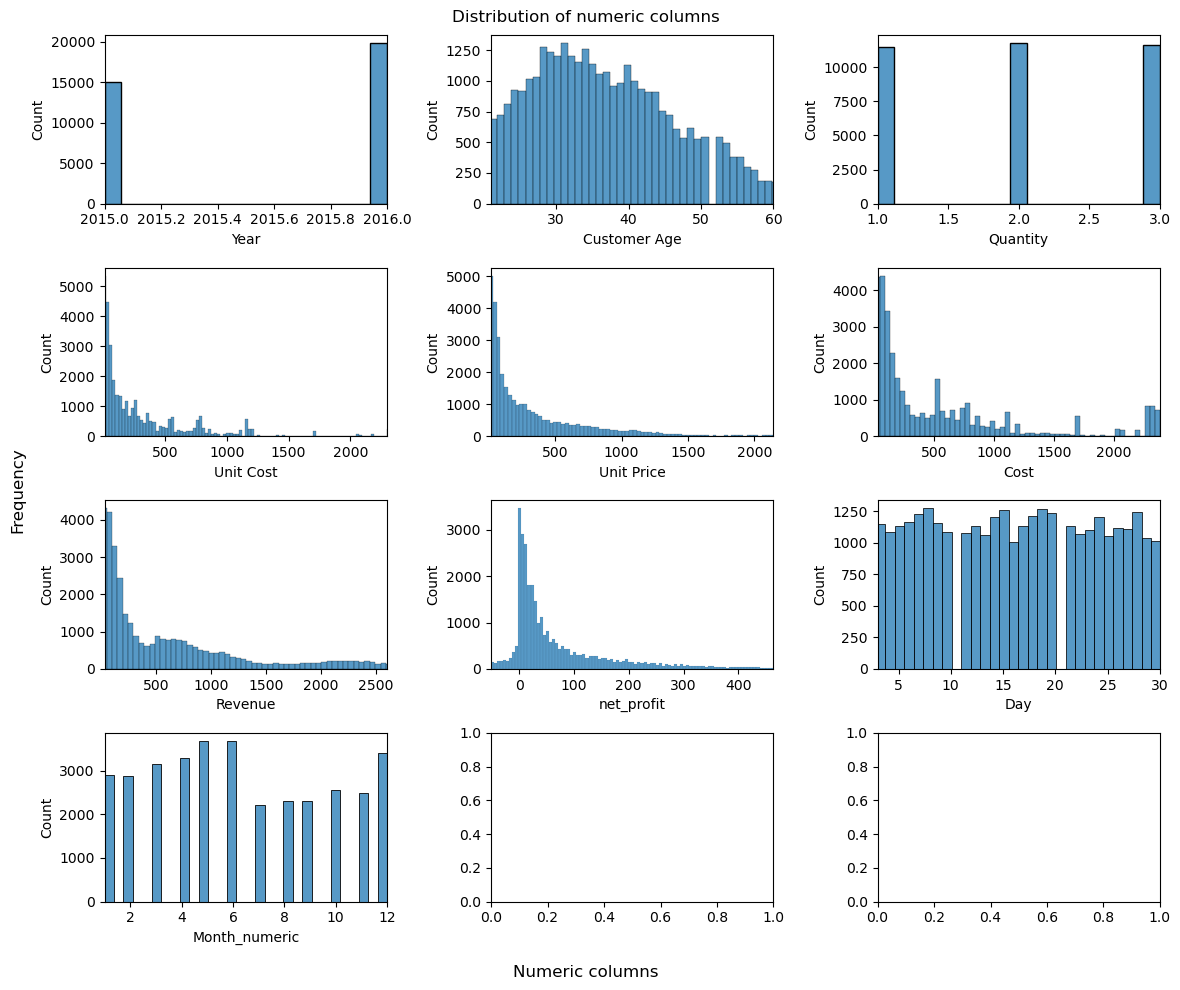

In [13]:
#| label: histplot
#| fig-cap: "Histogram plots of numeric columns"
df_histplot(sales_df)

From the above figures, we observed that most of the distributions were of skewed distribution, except for customer's age.

Customer's age appears to be a normal distribution, we would need to run a Shapiro test or a KS test in orde to determine if the distrubution is indeed normal.

In [14]:
def df_catplot(df, column_number):
    pass

## Statistical tests

First, let's investigate the claim of gender having no relation with revenue generated

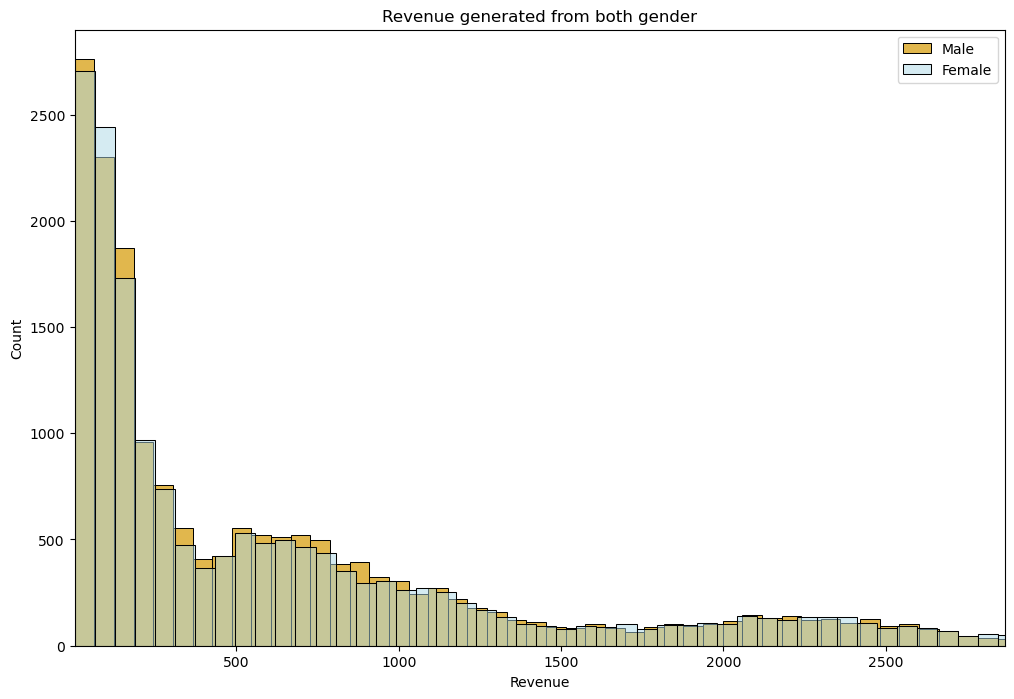

In [15]:
plt.figure(figsize = (12, 8))
sns.histplot(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                color='goldenrod', alpha = 0.8, label = 'Male')
sns.histplot(sales_df[sales_df['Customer Gender'] == 'F'].Revenue, 
                color='lightblue', alpha = 0.5, label = 'Female')
plt.xlim((sales_df['Revenue'].min(), sales_df['Revenue'].quantile(0.99)))
plt.title('Revenue generated from both gender')
plt.legend()
plt.show()

From the figure above, we can see that the two distributions from each gender are almost identical.

However, it apperas that the distributions consist of 3 difference distribution, with a right skewed, long tail distribution (likely to be from product sales with low pricing),
and 2 gaussian mixture distributions (centered at 600 and 2200)

In [16]:
sales_df['Product Category'].unique()

array(['Accessories', 'Clothing', 'Bikes'], dtype=object)

Coincidently, it apperas that we have exactly 3 different product categories. Let's investigate if these 3 product correspond to the 3 distributions we see.

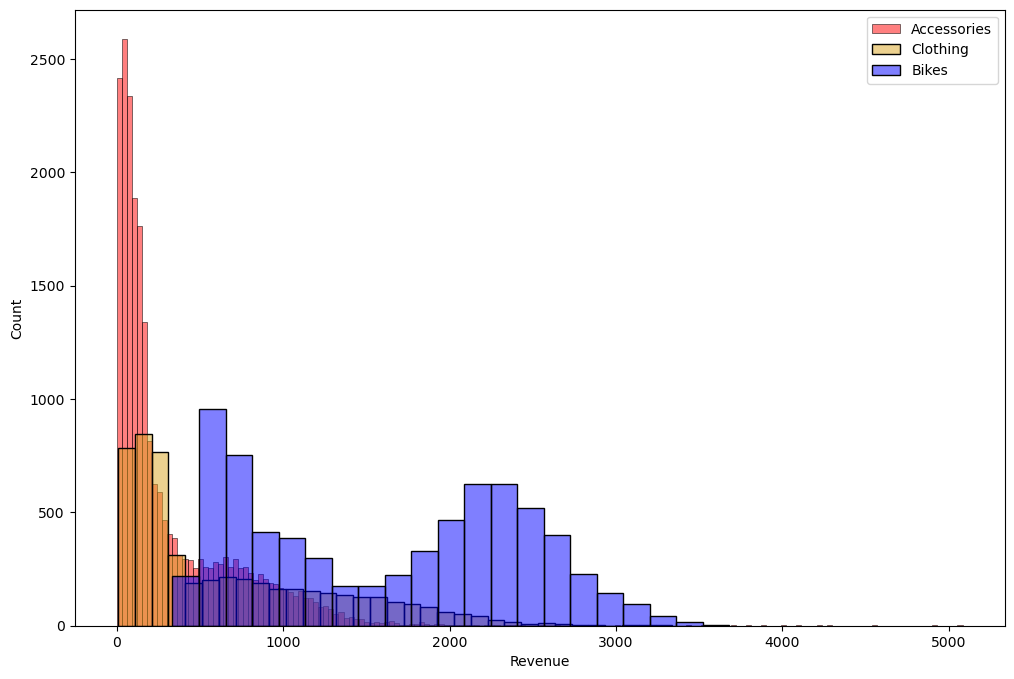

In [17]:
plt.figure(figsize=(12, 8))
for prod, color in zip(sales_df['Product Category'].unique(), ['red', 'goldenrod', 'blue']):
    sns.histplot(sales_df[sales_df['Product Category'] == prod]['Revenue'], 
    label = prod, color=color, alpha = 0.5)
plt.legend()
plt.show()

It appers that our guess was wrong, both accessories and cloting made up the right-skewed distribution, whereas the gaussian mixture distributin was from bikes category alone.

<AxesSubplot: xlabel='Revenue', ylabel='Count'>

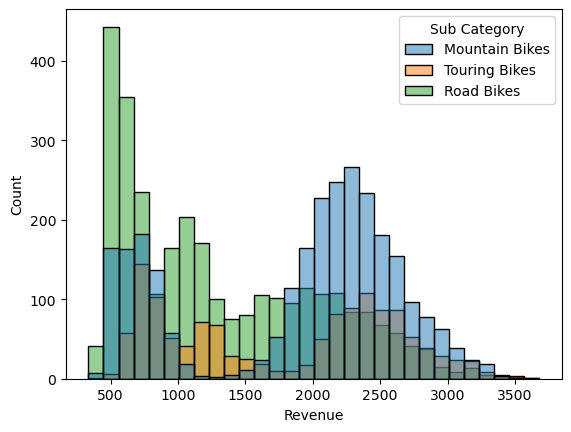

In [18]:
bike_df = sales_df[sales_df['Product Category'] == 'Bikes']
sns.histplot(bike_df, x='Revenue', hue='Sub Category', bins=30, palette='tab10', alpha=0.5)

## T-test on revenues generated for different gender.

To determine if different gender had different spending habits, we will be running a unpaired t-test to investigate if the two distribution is the same.

The hypothesis of a unpaired t-test is as follows:
$$H_0: \bar{X} - \bar{Y} = 0$$
$$H_1: \bar{X} - \bar{Y} \neq 0$$

where X and Y are the two distribution compared.

In [19]:
ttest_stat, ttest_p = scipy.stats.ttest_ind(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                   sales_df[sales_df['Customer Gender'] == 'F'].Revenue )

print(f'The p-vale for unpaired t-test for both gender is {ttest_p:.4f}')

The p-vale for unpaired t-test for both gender is 0.9855


Indeed, we can see that the p-value is around 0.98, which is highly unlikely that the mean of revenue spent for each gender were different.

> However, from the distribution above, we can see that it is highly not normal. Although we do have 34688 entries, and the central limit theorem works in our favour, and the assumption of similar means from any sample drawn from the distribution is the same.

Just to be safe, we will be running a Wilcoxon test (alternative non-parametric t-test).

## Mann-whitney U test for revenues generated by eahc gender.

In [20]:
whitney_stat, whitney_p = scipy.stats.mannwhitneyu(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                   sales_df[sales_df['Customer Gender'] == 'F'].Revenue )

print(f'The p-vale for unpaired t-test for both gender is {whitney_p:.4f}')


The p-vale for unpaired t-test for both gender is 0.2144


### Conclusion
Indeed, from the p-value above, we can see that it is still higher than the threshold of 5%. 

>> There is no statistical significant that each gender had different spending habit!

# Relation between gender and product purchased

Now that we have determined that the amount spent had no relation to the gender of customers, let's investigate if there was any difference of product bought for each gender.

Let's look at the frequency table for product categories and gender.

In [21]:
gender_category_df = sales_df.groupby(['Customer Gender', 'Product Category'])['Product Category'] \
                        .count().unstack().T

gender_category_df

Customer Gender       F      M
Product Category              
Accessories       11042  11492
Bikes              3514   3579
Clothing           2505   2734

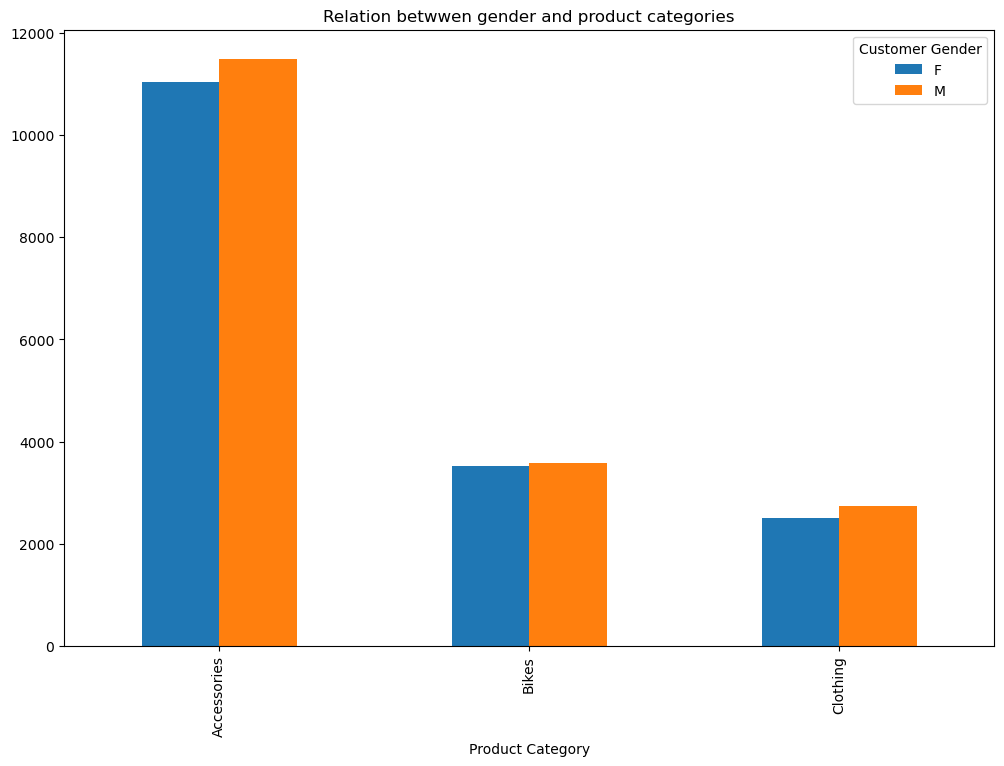

In [22]:
gender_category_df.plot(kind = 'bar', figsize=(12, 8))
plt.title('Relation betwwen gender and product categories')
plt.show()

From the table, we can see that for each product cetegory, the distribution was in a similar scale, with slightly more frequency for male's clothing transaction.

Although the numbers are quite similar, we still need to convert the corresponding chi2 statistic to our p-value of chi2 distribution, in this case, the degree of freedom (DOF) used will be the parameters in variable's number of categories:

$$
\begin{aligned}
DOF & = (\text{\# of product categories - 1}) \times (\text{\# of gender categories - 1})
\\
DOF & = 2
\end{aligned}
$$

We will be using scipy's chi2 test of independence for contigency tables. 

The hypothesis are as follows:

$$ H_0 = \text{The relation between variables are independent}$$
$$ H_1 = \text{The relation between batiables are not independent}$$

In [23]:
scipy.stats.chi2_contingency(gender_category_df)

(3.7174085431453174,
 0.15587447055732034,
 2,
 array([[11026.57528825, 11507.42471175],
        [ 3470.82180348,  3622.17819652],
        [ 2563.60290828,  2675.39709172]]))

From the above result, we can see that the p-value is 0.1558, which we failed to reject the null hypothesis that gender is independent of product bought.

## Conclusion

>> There is no statistical significant proof that gender is related to product bought.

In [24]:
def chi2_test(df, col1, col2, show_table = True):
    assert col1 in df.columns and col2 in df.columns, 'Column names provide can not be found in dataframe!'
    _cont = df.groupby([col1, col2])[col2].count().unstack()
    _result = scipy.stats.chi2_contingency(_cont)
    if show_table:
        print('------------------------------')
        print('Observed contigency table')
        display(_cont)
        print('------------------------------')
        print('Expected frequency table')
        display(pd.DataFrame(_result[-1], index = _cont.index, 
                    columns = _cont.columns))
    print(f'The p-value of chi2 independence test is {_result[1]:.4f}')

In [25]:
chi2_test(sales_df, 'Country', 'Product Category')

------------------------------
Observed contigency table


Product Category  Accessories  Bikes  Clothing
Country                                       
France                   3293   1152       723
Germany                  3200   1291       710
United Kingdom           3986   1497       938
United States           12055   3153      2868

------------------------------
Expected frequency table


Product Category   Accessories        Bikes     Clothing
Country                                                 
France             3340.093845  1051.357311   776.548844
Germany            3361.421844  1058.070699   781.507457
United Kingdom     4149.911490  1306.262634   964.825876
United States     11682.572822  3677.309356  2716.117823

The p-value of chi2 independence test is 0.0000


>> From the above result, we can see that there was deviation in sales, especially between United States with other countries. Infact, the corresponding p-value is 0, indicating there is a relation between the distribution of product sold and countries.

# Clustering analysis

After we have established that there are no interesting relation between the variables, let's dive deep into clustering analysis.

The aim of this section is to analyize customers behaviours, and determine if there are any groups with different spending habits, corresponding to different demographics.

In [26]:
sales_df.head()

Date  Year     Month  Customer Age Customer Gender        Country  \
index                                                                          
0      02/19/16  2016  February            29               F  United States   
1      02/20/16  2016  February            29               F  United States   
2      02/27/16  2016  February            29               F  United States   
3      03/12/16  2016     March            29               F  United States   
4      03/12/16  2016     March            29               F  United States   

            State Product Category     Sub Category  Quantity  Unit Cost  \
index                                                                      
0      Washington      Accessories  Tires and Tubes       1.0      80.00   
1      Washington         Clothing           Gloves       2.0      24.50   
2      Washington      Accessories  Tires and Tubes       3.0       3.67   
3      Washington      Accessories  Tires and Tubes       2.0      87.50   
4      Washington      Accessories  Tires and Tubes       3.0      35.00   

       Unit Price   Cost  Revenue  net_profit  Day  Month_numeric  
index                                                              
0      109.000000   80.0    109.0          29   19              2  
1       28.500000   49.0     57.0           8   20              2  
2        5.000000   11.0     15.0           4   27              2  
3      116.500000  175.0    233.0          58   12              3  
4       41.666667  105.0    125.0          20   12              3

Before we can continue to our analysis, we have to preprocess several things, notice that we have several categorical categories:

In [27]:
sales_df.select_dtypes('object').columns

Index(['Date', 'Month', 'Customer Gender', 'Country', 'State',
       'Product Category', 'Sub Category'],
      dtype='object')

We will be excluding the Date and Month columns, as the purpose is not a time series analysis, and the categorical columns will be one-hot encoded, in order to be feed in to a clustering algorithm.

In [28]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

From our previous analysis in Tableau, we have singled out that California state and England has some interesting behaviour, which their revenues increased significantly overtime.

For this reason, we will single out California state and treat it as a seperate entry in the Country column.

In [29]:
sales_df['Country_with_California'] = sales_df.apply(lambda x: x['Country'] if x['State'] != 'California' 
                                                        else 'California', axis = 1)

<AxesSubplot: >

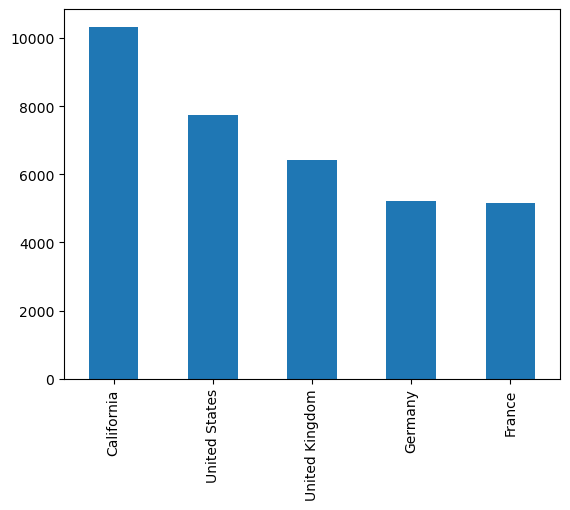

In [30]:
sales_df['Country_with_California'].value_counts().plot(kind='bar')

In [31]:
unwanted_col = ['Date', 'Year', 'Month', 'Quantity', 'Unit Cost', 'Unit Price', 'Day', 'Month_numeric', 
                    'Country', 'Sub Category', 'State']
remaining_col = [x for x in list(sales_df.columns) if x not in unwanted_col]
remaining_col

['Customer Age',
 'Customer Gender',
 'Product Category',
 'Cost',
 'Revenue',
 'net_profit',
 'Country_with_California']

In [32]:
clustering_df = sales_df[remaining_col]

In [33]:
clustering_df.head()

Customer Age Customer Gender Product Category   Cost  Revenue  \
index                                                                  
0                29               F      Accessories   80.0    109.0   
1                29               F         Clothing   49.0     57.0   
2                29               F      Accessories   11.0     15.0   
3                29               F      Accessories  175.0    233.0   
4                29               F      Accessories  105.0    125.0   

       net_profit Country_with_California  
index                                      
0              29           United States  
1               8           United States  
2               4           United States  
3              58           United States  
4              20           United States

In [34]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), ['Customer Gender', 'Country_with_California', 
                            'Product Category'])], 
                        # ('mmscaler', MinMaxScaler(), make_column_selector(dtype_include=['number', 'object']))],
                       remainder='passthrough', 
                       verbose_feature_names_out=False) 

In [35]:
pipe = Pipeline([('ohe', ct), 
                ('mascaler', MaxAbsScaler())])
                # ('clustering', DBSCAN())])

In [36]:
clustering_transformed = pipe.fit_transform(clustering_df)

In [37]:
clustering_tf_df = pd.DataFrame(clustering_transformed, 
                                columns=pipe.get_feature_names_out())
clustering_tf_df

Customer Gender_F  Customer Gender_M  \
0                    1.0                0.0   
1                    1.0                0.0   
2                    1.0                0.0   
3                    1.0                0.0   
4                    1.0                0.0   
...                  ...                ...   
34861                0.0                1.0   
34862                0.0                1.0   
34863                0.0                1.0   
34864                0.0                1.0   
34865                0.0                1.0   

       Country_with_California_California  Country_with_California_France  \
0                                     0.0                             0.0   
1                                     0.0                             0.0   
2                                     0.0                             0.0   
3                                     0.0                             0.0   
4                                     0.0                             0.0   
...                                   ...                             ...   
34861                                 0.0                             1.0   
34862                                 0.0                             1.0   
34863                                 0.0                             1.0   
34864                                 0.0                             1.0   
34865                                 0.0                             1.0   

       Country_with_California_Germany  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   
...                                ...   
34861                              0.0   
34862                              0.0   
34863                              0.0   
34864                              0.0   
34865                              0.0   

       Country_with_California_United Kingdom  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
...                                       ...   
34861                                     0.0   
34862                                     0.0   
34863                                     0.0   
34864                                     0.0   
34865                                     0.0   

       Country_with_California_United States  Product Category_Accessories  \
0                                        1.0                           1.0   
1                                        1.0                           0.0   
2                                        1.0                           1.0   
3                                        1.0                           1.0   
4                                        1.0                           1.0   
...                                      ...                           ...   
34861                                    0.0                           0.0   
34862                                    0.0                           0.0   
34863                                    0.0                           0.0   
34864                                    0.0                           0.0   
34865                                    0.0                           0.0   

       Product Category_Bikes  Product Category_Clothing  Customer Age  \
0                         0.0                        0.0      0.333333   
1                         0.0                        1.0      0.333333   
2                         0.0                        0.0      0.333333   
3                         0.0                        0.0      0.333333   
4                         0.0                        0.0      0.333333   
...                       ...             

In [38]:
dbs = DBSCAN()

dbs_result = dbs.fit(clustering_tf_df)


#| label: silhouette_core
#| fig-cap: Representation of silhouette score, highlighting the inter-cluster distance and extra-cluster distance.
To determine if the clustering is a good representation, we will be using the silhouette_score from sklearn.

The silhouette score is a metric defined to quantify how well the clustering is performing, by calculating the ratio between 

* The mean distance of points in the same cluster (intra-cluster distance)
* Distance from points to nearest other clusters.

It represents how confidence of the points being in a 'correct' cluster.

For more information, please refer to the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

<img src="https://miro.medium.com/max/875/1*YFpqMNrfi8pjaU28zpjs0g.png">

In [39]:
silhouette_score(clustering_tf_df, dbs_result.labels_)

0.8174959664660164

## K-prototype clustering

In the previous sub-section, we have explored the option of clustering the dataframe by one-hot-encoding. However, this method is not all sensible. The distance metric was arbitrary, although the Mahalanobis distance was used, there is no guarantee that the distance calculated is a good representation of the datapoints clustering (how is the distance between California and England comparable with the distance of $200 difference in revenue?).

Another method we will be using is the K-Prototypes clustering, which is a combination of K-means and K-modes algorithms.

In [40]:
from kmodes.kprototypes import KPrototypes

In [41]:
clustering_df.head()

Customer Age Customer Gender Product Category   Cost  Revenue  \
index                                                                  
0                29               F      Accessories   80.0    109.0   
1                29               F         Clothing   49.0     57.0   
2                29               F      Accessories   11.0     15.0   
3                29               F      Accessories  175.0    233.0   
4                29               F      Accessories  105.0    125.0   

       net_profit Country_with_California  
index                                      
0              29           United States  
1               8           United States  
2               4           United States  
3              58           United States  
4              20           United States

In [42]:
numeric_scaler = ColumnTransformer([('std_scaler', StandardScaler(), 
                        make_column_selector(dtype_include='number'))], 
                        remainder = 'passthrough', 
                        verbose_feature_names_out=False)

clustering_scaled_df = pd.DataFrame(numeric_scaler.fit_transform(clustering_df),  
                                    columns = numeric_scaler.get_feature_names_out()).apply(lambda x: pd.to_numeric(x, errors='ignore'))

clustering_scaled_df


Customer Age      Cost   Revenue  net_profit Customer Gender  \
0         -0.664363 -0.718337 -0.722022   -0.234603               F   
1         -0.664363 -0.763232 -0.792612   -0.371968               F   
2         -0.664363 -0.818265 -0.849628   -0.398132               F   
3         -0.664363 -0.580753 -0.553690   -0.044909               F   
4         -0.664363 -0.682130 -0.700301   -0.293473               F   
...             ...       ...       ...         ...             ...   
34861      0.145518  2.133260  1.148634   -4.100438               M   
34862      0.145518  2.525734  1.805672   -2.707167               M   
34863      0.145518  2.133260  1.278956   -3.472485               M   
34864      0.145518  2.133260  1.413350   -2.824908               M   
34865      0.145518  2.525734  1.258593   -5.343261               M   

      Product Category Country_with_California  
0          Accessories           United States  
1             Clothing           United States  
2          Accessories           United States  
3          Accessories           United States  
4          Accessories           United States  
...                ...                     ...  
34861            Bikes                  France  
34862            Bikes                  France  
34863            Bikes                  France  
34864            Bikes                  France  
34865            Bikes                  France  

[34866 rows x 7 columns]

In [43]:
clustering_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34866 entries, 0 to 34865
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer Age             34866 non-null  float64
 1   Cost                     34866 non-null  float64
 2   Revenue                  34866 non-null  float64
 3   net_profit               34866 non-null  float64
 4   Customer Gender          34866 non-null  object 
 5   Product Category         34866 non-null  object 
 6   Country_with_California  34866 non-null  object 
dtypes: float64(4), object(3)
memory usage: 1.9+ MB


In [44]:
cat_position = [clustering_scaled_df.columns.get_loc(col) for col in 
                    clustering_scaled_df.select_dtypes('object').columns]
cat_position

[4, 5, 6]

In [45]:

clustering_scaled_df.select_dtypes('object').columns

Index(['Customer Gender', 'Product Category', 'Country_with_California'], dtype='object')

In [46]:
kproto_results ={'cluster_size': [], 'cost':[]} 

clustering_scaled_df_sample = clustering_scaled_df.sample(frac=0.5)

for cluster_size in range(1, 8):
    print(f'Fitting Kprototypes for cluster size :{cluster_size}')
    _kproto = KPrototypes(n_clusters=cluster_size)
    _labels = _kproto.fit_predict(clustering_scaled_df_sample, categorical = cat_position)
    kproto_results['cluster_size'].append(cluster_size)
    kproto_results['cost'].append(_kproto.cost_)
    print(f'Cost: {_kproto.cost_}')
    print('----------------------------------------')

Fitting Kprototypes for cluster size :1
Cost: 82810.8485898071
----------------------------------------
Fitting Kprototypes for cluster size :2
Cost: 54922.59311047068
----------------------------------------
Fitting Kprototypes for cluster size :3
Cost: 44460.240000435595
----------------------------------------
Fitting Kprototypes for cluster size :4
Cost: 35819.132172014804
----------------------------------------
Fitting Kprototypes for cluster size :5
Cost: 31257.678923761563
----------------------------------------
Fitting Kprototypes for cluster size :6
Cost: 28840.456610797504
----------------------------------------
Fitting Kprototypes for cluster size :7
Cost: 26933.73970909414
----------------------------------------


In [47]:
# import pickle
# import os

# with open('kproto_result.pkl', 'wb') as file:
#     # assert not os.path.getsize(file) > 0, f"{file} already exists! Prone to overwriting."
#     pickle.dump(kproto_results, file=file)



In [48]:
import pickle

with open('./kproto_result.pkl', 'rb') as file:
    kproto_results = pickle.load(file)

Text(0, 0.5, 'Cost value')

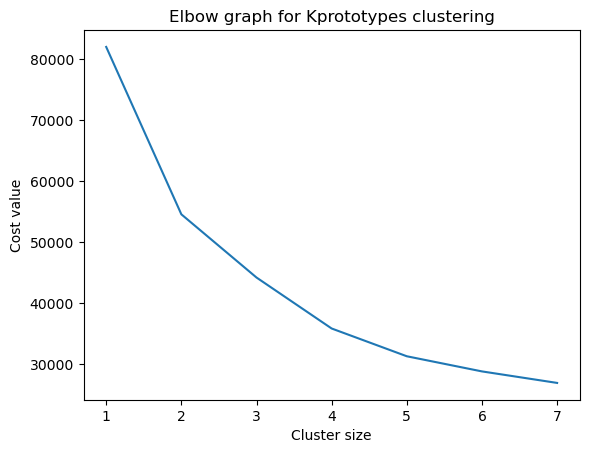

In [49]:
plt.plot(kproto_results['cluster_size'], kproto_results['cost'])
plt.title('Elbow graph for Kprototypes clustering')
plt.xlabel('Cluster size')
plt.ylabel('Cost value')

In [50]:
kproto_best = KPrototypes(5, random_state=43)
kproto_best_label = kproto_best.fit_predict(clustering_scaled_df, categorical = cat_position)

clustering_scaled_df['kproto_labels'] = kproto_best_label

In [51]:
clustering_scaled_df

Customer Age      Cost   Revenue  net_profit Customer Gender  \
0         -0.664363 -0.718337 -0.722022   -0.234603               F   
1         -0.664363 -0.763232 -0.792612   -0.371968               F   
2         -0.664363 -0.818265 -0.849628   -0.398132               F   
3         -0.664363 -0.580753 -0.553690   -0.044909               F   
4         -0.664363 -0.682130 -0.700301   -0.293473               F   
...             ...       ...       ...         ...             ...   
34861      0.145518  2.133260  1.148634   -4.100438               M   
34862      0.145518  2.525734  1.805672   -2.707167               M   
34863      0.145518  2.133260  1.278956   -3.472485               M   
34864      0.145518  2.133260  1.413350   -2.824908               M   
34865      0.145518  2.525734  1.258593   -5.343261               M   

      Product Category Country_with_California  kproto_labels  
0          Accessories           United States              2  
1             Clothing           United States              2  
2          Accessories           United States              2  
3          Accessories           United States              2  
4          Accessories           United States              2  
...                ...                     ...            ...  
34861            Bikes                  France              1  
34862            Bikes                  France              1  
34863            Bikes                  France              1  
34864            Bikes                  France              1  
34865            Bikes                  France              1  

[34866 rows x 8 columns]

In [52]:
clustering_ohe_df = ct.fit_transform(clustering_df)

clustering_ohe_df = pd.DataFrame(clustering_ohe_df, columns = ct.get_feature_names_out())

In [53]:
clustering_ohe_df.head()

Customer Gender_F  Customer Gender_M  Country_with_California_California  \
0                1.0                0.0                                 0.0   
1                1.0                0.0                                 0.0   
2                1.0                0.0                                 0.0   
3                1.0                0.0                                 0.0   
4                1.0                0.0                                 0.0   

   Country_with_California_France  Country_with_California_Germany  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   

   Country_with_California_United Kingdom  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   Country_with_California_United States  Product Category_Accessories  \
0                                    1.0                           1.0   
1                                    1.0                           0.0   
2                                    1.0                           1.0   
3                                    1.0                           1.0   
4                                    1.0                           1.0   

   Product Category_Bikes  Product Category_Clothing  Customer Age   Cost  \
0                     0.0                        0.0          29.0   80.0   
1                     0.0                        1.0          29.0   49.0   
2                     0.0                        0.0          29.0   11.0   
3                     0.0                        0.0          29.0  175.0   
4                     0.0                        0.0          29.0  105.0   

   Revenue  net_profit  
0    109.0        29.0  
1     57.0         8.0  
2     15.0         4.0  
3    233.0        58.0  
4    125.0        20.0

After performing the clustering with KPrototype algorithm, we wish to visualize how well the clustering is performing. Consider the nature of our dataset, with high dimensions and including categorical data, it is not obvious on which method should be choose to plot the data. 

As 3-dimensional figure is the most a human can comprehent, we would need some method in reducing out feature space into smaller dimension 

>>In mathematical sense, the method is called embedding, or projection, with the transformation being represented as a matrix, for more information refer to this [wiki site](https://en.wikipedia.org/wiki/Projection_matrix#Intuition), we won't go into the details in here, but the method we chose, the principal component analysis (PCA), was build on this idea, and the transformation which maximize the variance in newly transformed axis were found.

Althouth PCA is not ideal with mixed type of data (categorical and numerical features), it is more straighforward way, and slightly less computational expensive method than T-SNE.

We will choose to reduce our feature space's dimension to 5 dimensions, and produce a scatter graph which represents the different clusters our KPrototype algorithm produced.

In [54]:
from sklearn.decomposition import PCA

cluster_mean_scaler = MaxAbsScaler()
cluster_mean_scaler = ColumnTransformer([('scaler', StandardScaler(), ['Customer Age', 'Cost', 'Revenue', 'net_profit'])], 
                                        remainder='passthrough', 
                                        verbose_feature_names_out=False)

cluster_mean_scaled = pd.DataFrame(cluster_mean_scaler.fit_transform(clustering_ohe_df), 
                                    columns = cluster_mean_scaler.get_feature_names_out())
clustering_pca = PCA(5)
clustering_ohe_pca_df = clustering_pca.fit_transform(cluster_mean_scaled)
clustering_ohe_pca_df = pd.DataFrame(clustering_ohe_pca_df, 
                                    columns = clustering_pca.get_feature_names_out())

After our PCA dimensional reduction, we can see that the below dataframe representing our 5 new axis.

In [55]:
clustering_ohe_pca_df.head()

pca0      pca1      pca2      pca3      pca4
0 -1.139744 -0.592246  0.123655 -0.736167 -0.546489
1 -1.055139 -0.625459 -0.100063 -0.725438 -0.508202
2 -1.337121 -0.593514  0.011031 -0.735941 -0.552610
3 -0.883684 -0.591387  0.246809 -0.736383 -0.539416
4 -1.120503 -0.594745  0.058157 -0.735933 -0.548785

In [56]:
# Assigning cluster labels into our dataframe
clustering_ohe_pca_df['cluster'] = kproto_best_label

Text(0.5, 1.0, 'PCA visualization of Kprototype clusters')

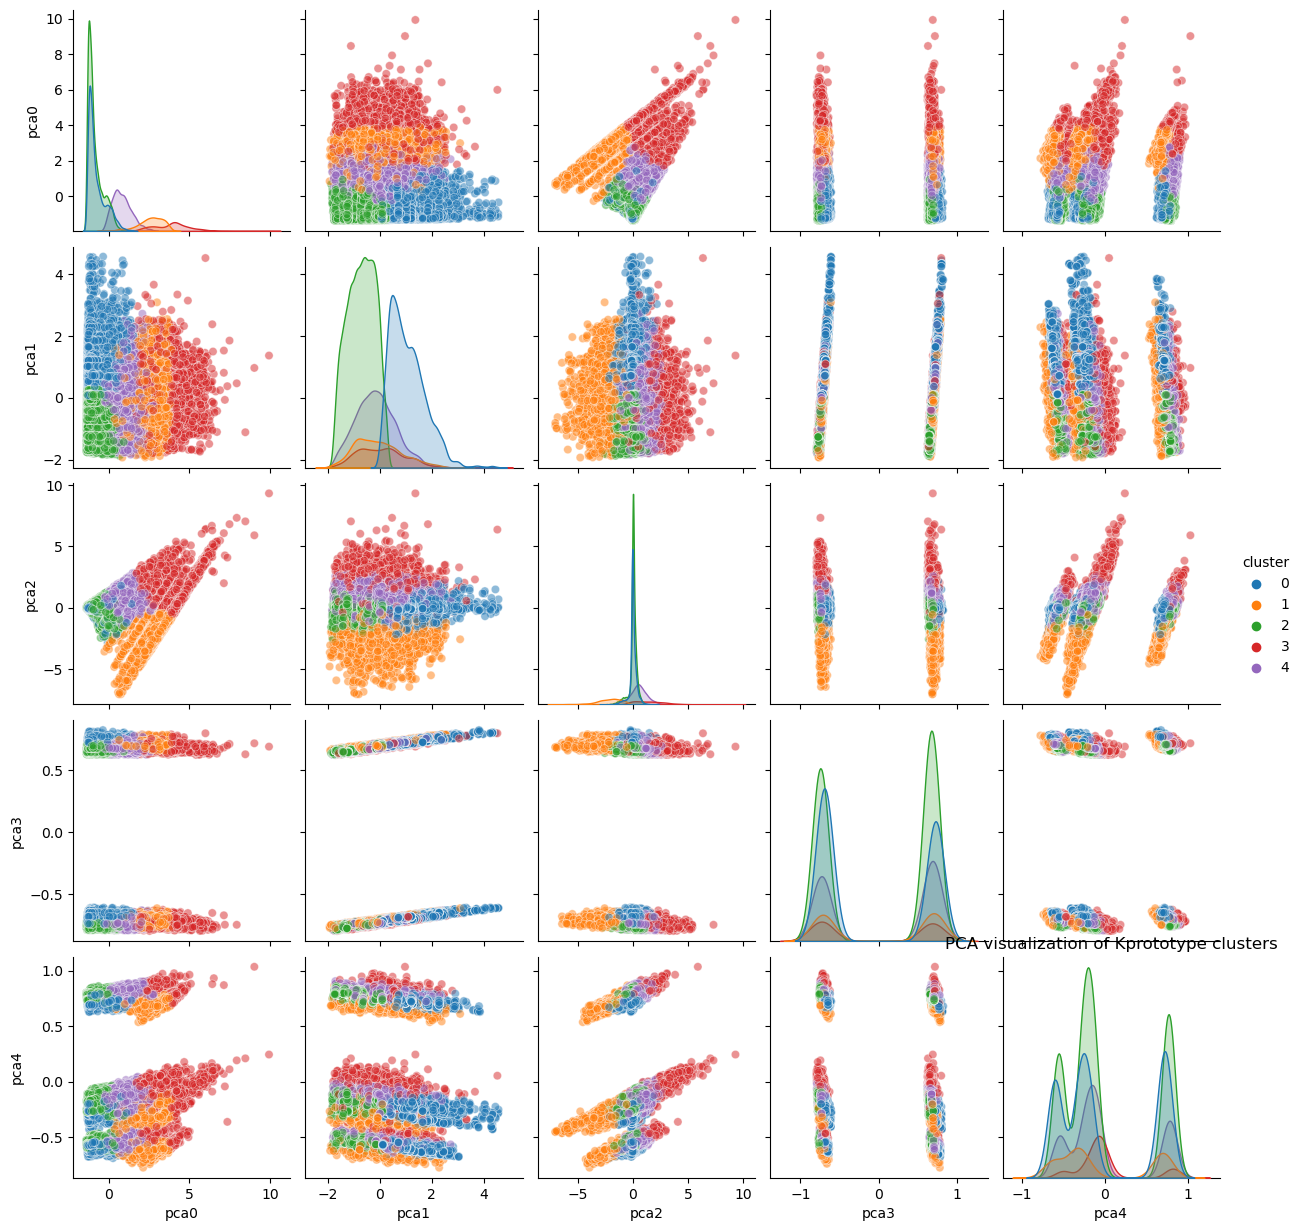

In [57]:
#| label: cluster_visual
#| fig-cap: Pairplot of the 5 new PCA axis, with each datapoint color coded with the cluster number.


sns.pairplot(clustering_ohe_pca_df, hue = 'cluster', palette='tab10', plot_kws = {'alpha' : 0.5})
plt.title('PCA visualization of Kprototype clusters')


For the above pairplot, we can see that the first PCA axes represent most of the varaince in our dataset, Starting from pca3, there is a clear seperation, and it's likely that the corresponding pca dimension is mostly contributed from out categorical features (contries, product categories etc).

> It can be noted that is no immediate clustering to be seen in our data. Although KPrototpe attempts to optimized by reducing the average distance between clusters, how well the clustering is performing highly depends on the nature of our dataset.

Instead of visualizing through PCA, we can quantify and visualize the different clusters by looking at the statistics of each cluster.

For our purpose, we will be looking at the average values of features foe each cluster.

In [58]:
clustering_ohe_df['cluster'] = kproto_best_label

In [59]:
clustering_ohe_df.groupby('cluster').mean()

Customer Gender_F  Customer Gender_M  \
cluster                                         
0                 0.560676           0.439324   
1                 0.485354           0.514646   
2                 0.450244           0.549756   
3                 0.523350           0.476650   
4                 0.447162           0.552838   

         Country_with_California_California  Country_with_California_France  \
cluster                                                                       
0                                  0.338068                        0.122899   
1                                  0.340378                        0.170560   
2                                  0.294088                        0.161551   
3                                  0.136548                        0.186802   
4                                  0.262883                        0.138943   

         Country_with_California_Germany  \
cluster                                    
0                               0.107246   
1                               0.021505   
2                               0.132099   
3                               0.449239   
4                               0.217873   

         Country_with_California_United Kingdom  \
cluster                                           
0                                      0.172367   
1                                      0.239896   
2                                      0.189254   
3                                      0.127919   
4                                      0.186236   

         Country_with_California_United States  Product Category_Accessories  \
cluster                                                                        
0                                     0.259420                      0.796522   
1                                     0.227660                      0.001483   
2                                     0.223008                      0.771889   
3                                     0.099492                      0.100000   
4                                     0.194064                      0.570939   

         Product Category_Bikes  Product Category_Clothing  Customer Age  \
cluster                                                                    
0                      0.063768                   0.139710     47.984638   
1                      0.952169                   0.046348     37.150908   
2                      0.086170                   0.141941     28.147263   
3                      0.695431                   0.204569     37.460406   
4                      0.214123                   0.214938     34.539465   

                Cost      Revenue  net_profit  
cluster                                        
0         230.139227   261.949855   31.810628  
1        2166.809047  2041.329996 -125.479051  
2         205.310418   227.842458   22.532041  
3        1975.811168  2433.172081  457.360914  
4         839.621331  1012.600130  172.978800

In [60]:
clustering_scaled_df

Customer Age      Cost   Revenue  net_profit Customer Gender  \
0         -0.664363 -0.718337 -0.722022   -0.234603               F   
1         -0.664363 -0.763232 -0.792612   -0.371968               F   
2         -0.664363 -0.818265 -0.849628   -0.398132               F   
3         -0.664363 -0.580753 -0.553690   -0.044909               F   
4         -0.664363 -0.682130 -0.700301   -0.293473               F   
...             ...       ...       ...         ...             ...   
34861      0.145518  2.133260  1.148634   -4.100438               M   
34862      0.145518  2.525734  1.805672   -2.707167               M   
34863      0.145518  2.133260  1.278956   -3.472485               M   
34864      0.145518  2.133260  1.413350   -2.824908               M   
34865      0.145518  2.525734  1.258593   -5.343261               M   

      Product Category Country_with_California  kproto_labels  
0          Accessories           United States              2  
1             Clothing           United States              2  
2          Accessories           United States              2  
3          Accessories           United States              2  
4          Accessories           United States              2  
...                ...                     ...            ...  
34861            Bikes                  France              1  
34862            Bikes                  France              1  
34863            Bikes                  France              1  
34864            Bikes                  France              1  
34865            Bikes                  France              1  

[34866 rows x 8 columns]

In [61]:
cluster_mean = clustering_ohe_df.groupby('cluster').mean()

cluster_mean_scaler = MaxAbsScaler()
cluster_mean_scaler = ColumnTransformer([('scaler', MaxAbsScaler(), ['Customer Age', 'Cost', 'Revenue', 'net_profit'])], 
                                        remainder='passthrough', 
                                        verbose_feature_names_out=False)
cluster_mean_scaled = pd.DataFrame(cluster_mean_scaler.fit_transform(cluster_mean), 
                                    columns = cluster_mean_scaler.get_feature_names_out())
cluster_mean_scaled

Customer Age      Cost   Revenue  net_profit  Customer Gender_F  \
0      1.000000  0.106211  0.107658    0.069553           0.560676   
1      0.774225  1.000000  0.838958   -0.274355           0.485354   
2      0.586589  0.094752  0.093640    0.049265           0.450244   
3      0.780675  0.911853  1.000000    1.000000           0.523350   
4      0.719803  0.387492  0.416165    0.378211           0.447162   

   Customer Gender_M  Country_with_California_California  \
0           0.439324                            0.338068   
1           0.514646                            0.340378   
2           0.549756                            0.294088   
3           0.476650                            0.136548   
4           0.552838                            0.262883   

   Country_with_California_France  Country_with_California_Germany  \
0                        0.122899                         0.107246   
1                        0.170560                         0.021505   
2                        0.161551                         0.132099   
3                        0.186802                         0.449239   
4                        0.138943                         0.217873   

   Country_with_California_United Kingdom  \
0                                0.172367   
1                                0.239896   
2                                0.189254   
3                                0.127919   
4                                0.186236   

   Country_with_California_United States  Product Category_Accessories  \
0                               0.259420                      0.796522   
1                               0.227660                      0.001483   
2                               0.223008                      0.771889   
3                               0.099492                      0.100000   
4                               0.194064                      0.570939   

   Product Category_Bikes  Product Category_Clothing  
0                0.063768                   0.139710  
1                0.952169                   0.046348  
2                0.086170                   0.141941  
3                0.695431                   0.204569  
4                0.214123                   0.214938

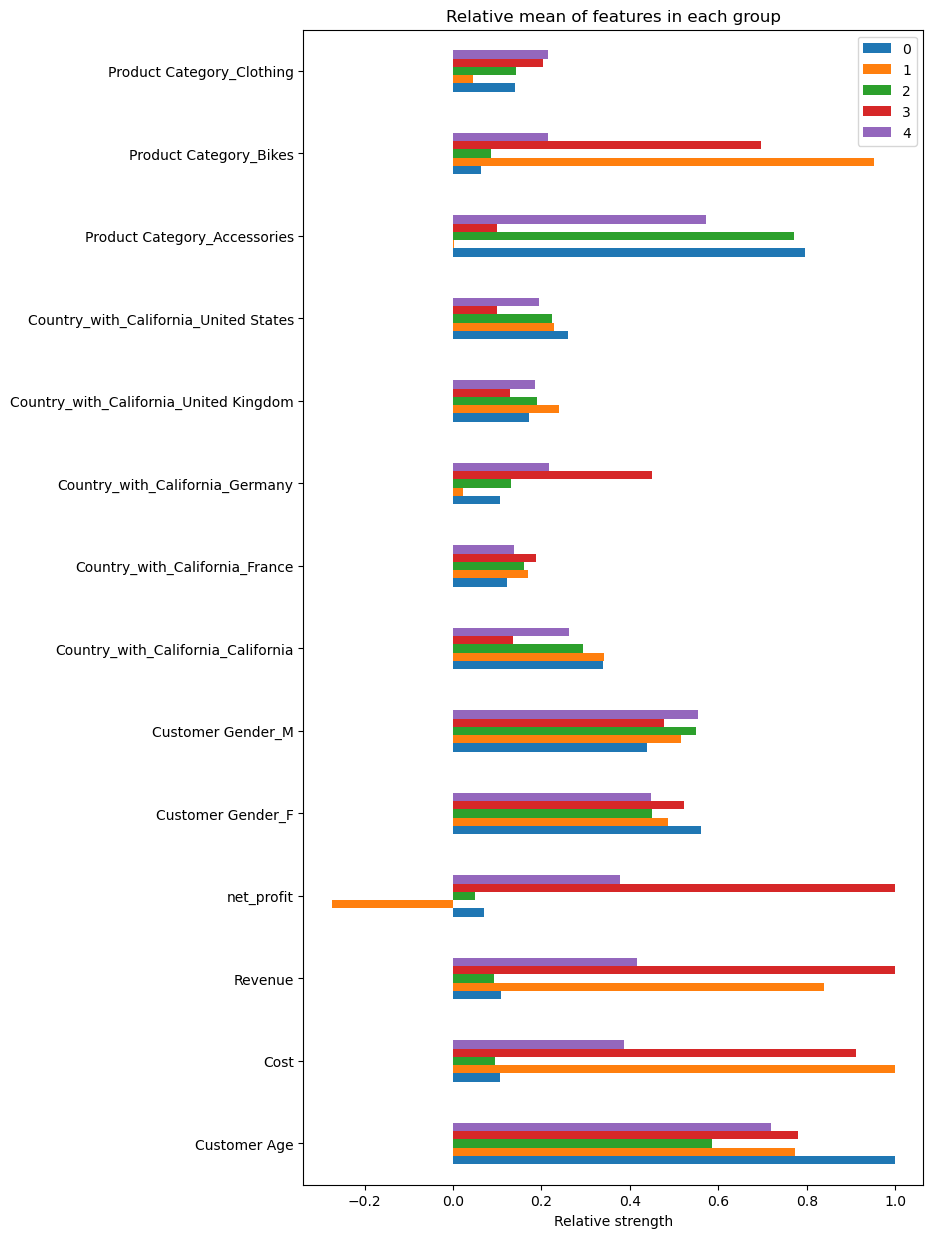

In [62]:
#| label: Averages of features within each group.
#| fig-cap: Comparison of each feature for clustered groups. Note that the values were scaled for numeric features. Eg, The group which generated most profit will have profit value of 1. The scaling used is MaxAbsScaling from sklearn, which preserve nagative values.
cluster_mean_scaled.T.plot(kind='barh', figsize = (8, 15))
plt.title('Relative mean of features in each group')
plt.xlabel('Relative strength')
plt.show()

In [63]:
# sns.barplot(clustering_ohe_df, x='cluster', 
#                 y = [x for x in list(clustering_ohe_df.columns) if x != 'cluster'], 
#                 estimator='mean')

In [64]:
melted = pd.melt(clustering_ohe_df, id_vars = ['cluster'])
melted

cluster           variable  value
0             2  Customer Gender_F    1.0
1             2  Customer Gender_F    1.0
2             2  Customer Gender_F    1.0
3             2  Customer Gender_F    1.0
4             2  Customer Gender_F    1.0
...         ...                ...    ...
488119        1         net_profit -562.0
488120        1         net_profit -349.0
488121        1         net_profit -466.0
488122        1         net_profit -367.0
488123        1         net_profit -752.0

[488124 rows x 3 columns]

<AxesSubplot: xlabel='value', ylabel='cluster'>

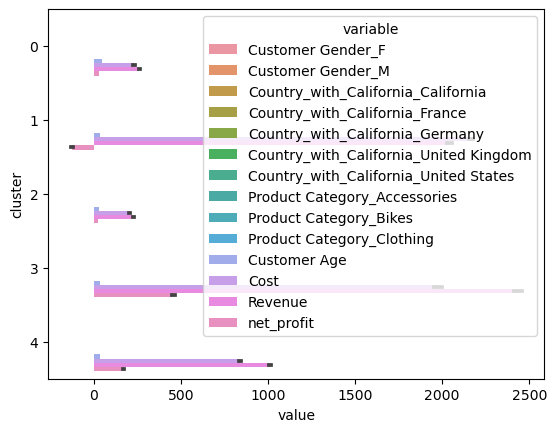

In [67]:
sns.barplot(melted, x='value',y='cluster',  hue = 'variable', orient='h')

In [66]:
cluster_mean_scaled

Customer Age      Cost   Revenue  net_profit  Customer Gender_F  \
0      1.000000  0.106211  0.107658    0.069553           0.560676   
1      0.774225  1.000000  0.838958   -0.274355           0.485354   
2      0.586589  0.094752  0.093640    0.049265           0.450244   
3      0.780675  0.911853  1.000000    1.000000           0.523350   
4      0.719803  0.387492  0.416165    0.378211           0.447162   

   Customer Gender_M  Country_with_California_California  \
0           0.439324                            0.338068   
1           0.514646                            0.340378   
2           0.549756                            0.294088   
3           0.476650                            0.136548   
4           0.552838                            0.262883   

   Country_with_California_France  Country_with_California_Germany  \
0                        0.122899                         0.107246   
1                        0.170560                         0.021505   
2                        0.161551                         0.132099   
3                        0.186802                         0.449239   
4                        0.138943                         0.217873   

   Country_with_California_United Kingdom  \
0                                0.172367   
1                                0.239896   
2                                0.189254   
3                                0.127919   
4                                0.186236   

   Country_with_California_United States  Product Category_Accessories  \
0                               0.259420                      0.796522   
1                               0.227660                      0.001483   
2                               0.223008                      0.771889   
3                               0.099492                      0.100000   
4                               0.194064                      0.570939   

   Product Category_Bikes  Product Category_Clothing  
0                0.063768                   0.139710  
1                0.952169                   0.046348  
2                0.086170                   0.141941  
3                0.695431                   0.204569  
4                0.214123                   0.214938

In [67]:
[x for x in list(clustering_ohe_df.columns) if x != 'cluster']

['Customer Gender_F',
 'Customer Gender_M',
 'Country_with_California_California',
 'Country_with_California_France',
 'Country_with_California_Germany',
 'Country_with_California_United Kingdom',
 'Country_with_California_United States',
 'Product Category_Accessories',
 'Product Category_Bikes',
 'Product Category_Clothing',
 'Customer Age',
 'Cost',
 'Revenue',
 'net_profit']

The most interesting result from above is the cluster with negative net_profit. From the mean of the analysis, we can see tha the sales were contributed from bike sales, which this cluster also almost contains no sales from Germany.

Not only that, cluster with really high percent of sales from Germany (cluster 3) has a much higher net_profit, comparing to other clusters.It suggested that bike sales in Germany generates profit, however, bike sales in other countries actually results in loss in profit.

>> Further investigation is needed to determine the relation between the types of bikes being sold in Germany, and the profit generated.

# Hyperparameter tuning

Now that we have demonstrated on how to peform clustering by using DBSCAN, we will move on to tuning the hyperparameters, to obtain the clustering with best silhoutte score.

[optuna](https://optuna.readthedocs.io/en/stable/) is a hyperparameter framework, which optimizes python loops to exhaust the search space automatically. 

Alternative to Optuna, a function of manaul Python loops can be written, Sklearn GridSearchCV would be incompatible, since clustering algorithm (such as DBSCAN) lacks a `.transform()` method.

In [68]:
import optuna
from sklearn.neighbors import DistanceMetric

In [69]:
mahala = DistanceMetric.get_metric('mahalanobis', V=np.cov(clustering_tf_df.to_numpy().T))

/home/shiya/anaconda3/envs/clustering/lib/python3.8/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [70]:
dbs_test = DBSCAN(metric=mahala)

In [71]:
np.cov(clustering_tf_df.to_numpy().T).shape

(14, 14)

In [72]:
# Defining variables needed to calculate Malahanobis distance
df_cov = np.cov(clustering_tf_df.to_numpy().T)
mahala = DistanceMetric.get_metric('mahalanobis', V=df_cov)
assert df_cov.shape == (clustering_tf_df.shape[1],
                        clustering_tf_df.shape[1])

def objective(trial):

    _epsilon = trial.suggest_float('_epsilon', 0.1, 2)
    _min_samples = trial.suggest_int('_min_samples', 5, 1000, log= True)
    _distance = trial.suggest_categorical('_distance', ['euclidean', 'manhattan', 'mahalanobis'])
    if _distance == 'mahalanobis':
        _dbs = DBSCAN(eps=_epsilon, min_samples=_min_samples, metric=_distance, metric_params={'V':df_cov})
    else:
        _dbs = DBSCAN(eps=_epsilon, min_samples=_min_samples, metric=_distance)
    _dbs.fit(clustering_tf_df)
    try:
        if _distance =='mahalanobis':
            return silhouette_score(clustering_tf_df, _dbs.labels_, metric=_distance, 
                                    # We will reduce the sample_size for calculating silhouette score,
                                    # as the calculation is computationally expensive.
                                    sample_size = int(clustering_tf_df.shape[0]*0.6), random_state = 42, 
                                    V=df_cov)
        else:
            return silhouette_score(clustering_tf_df, _dbs.labels_, metric=_distance, 
                                    # We will reduce the sample_size for calculating silhouette score,
                                    # as the calculation is computationally expensive.
                                    sample_size = int(clustering_tf_df.shape[0]*0.6), random_state = 42) 
    except:
        return 0

In [73]:
{1:2 if 1==2 else None}

{1: None}

In [74]:
study = optuna.create_study()
study.optimize(objective, n_trials = 20)

[I 2023-01-25 20:36:23,382] A new study created in memory with name: no-name-5bb0c7cc-67e7-443d-bafd-125d796ebc4d


: 

: 

In [ ]:
clustering_tf_df.shape

(34866, 14)

In [ ]:
# dbs_dict = {'epsilon':[], 'min_sample':[], 'sil_score':[]}

# for ep in np.linspace(0.1, 4, 20):
#     for minsamp in np.logspace(5, 1000, 20):
#         for _distance in ['euclidean', 'manhattan']:
#             print(f'Fitting on epsion: {ep}, minimum_sample: {minsamp} with distance: {_distance}')
#             _dbs = DBSCAN(eps=ep, min_samples=minsamp, metric=_distance)
#             _dbs.fit(clustering_tf_df)
#             dbs_dict['epsilon'].append(ep)
#             dbs_dict['min_sample'].append(minsamp)
#             try:
#                 sil_score = silhouette_score(clustering_tf_df, _dbs.labels_, metric=_distance, 
#                                             sample_size = int(clustering_tf_df.shape[0]*0.6), random_state = 42)
#             except:
#                 sil_score = 0
#             dbs_dict['sil_score'].append(sil_socre)
#             print(dbs_dict)
